# Test read

In [8]:
import numpy as np

In [2]:
!ls -l -t

total 29560
-rw-r--r--  1 dagoret  staff       72 Jun 11 23:13 Untitled.ipynb
-rw-r--r--  1 dagoret  staff   913299 Jun 11 22:34 demo_obj0_dynesty_23Jun11-20.52_result.h5
-rw-r--r--  1 dagoret  staff  1706064 Jun 11 20:51 demo_obj1_emcee_23Jun11-20.40_result.h5
-rw-r--r--  1 dagoret  staff  1705976 Jun 11 20:35 demo_obj0_emcee_23Jun11-20.23_result.h5
-rw-r--r--  1 dagoret  staff  1586712 Jun 11 20:18 demo_obj0_emcee_23Jun11-20.06_result.h5
-rw-r--r--  1 dagoret  staff  1586592 Jun 11 18:04 demo_obj0_emcee_23Jun11-17.51_result.h5
-rw-r--r--  1 dagoret  staff      414 Jun 11 17:50 demo_photometry.dat
-rw-r--r--  1 dagoret  staff     3522 Jun 11 17:43 timing.py
-rw-r--r--  1 dagoret  staff      760 Jun 11 17:43 mpi_hello_world.py
-rw-r--r--  1 dagoret  staff    11776 Jun 11 17:43 demo_params.py
-rw-r--r--  1 dagoret  staff    13946 Jun 11 17:43 demo_mpi_params.py
-rw-r--r--  1 dagoret  staff    10090 Jun 11 17:43 demo_mock_params.py
-rw-r--r--  1 dagoret  staff   364120 Jun 11 17:17 MyQui

In [3]:
import prospect.io.read_results as reader
#res, obs, model = reader.results_from("demo_obj_<fitter>_<timestamp>_mcmc.h5")
res, obs, model = reader.results_from("demo_obj1_emcee_23Jun11-20.40_result.h5")

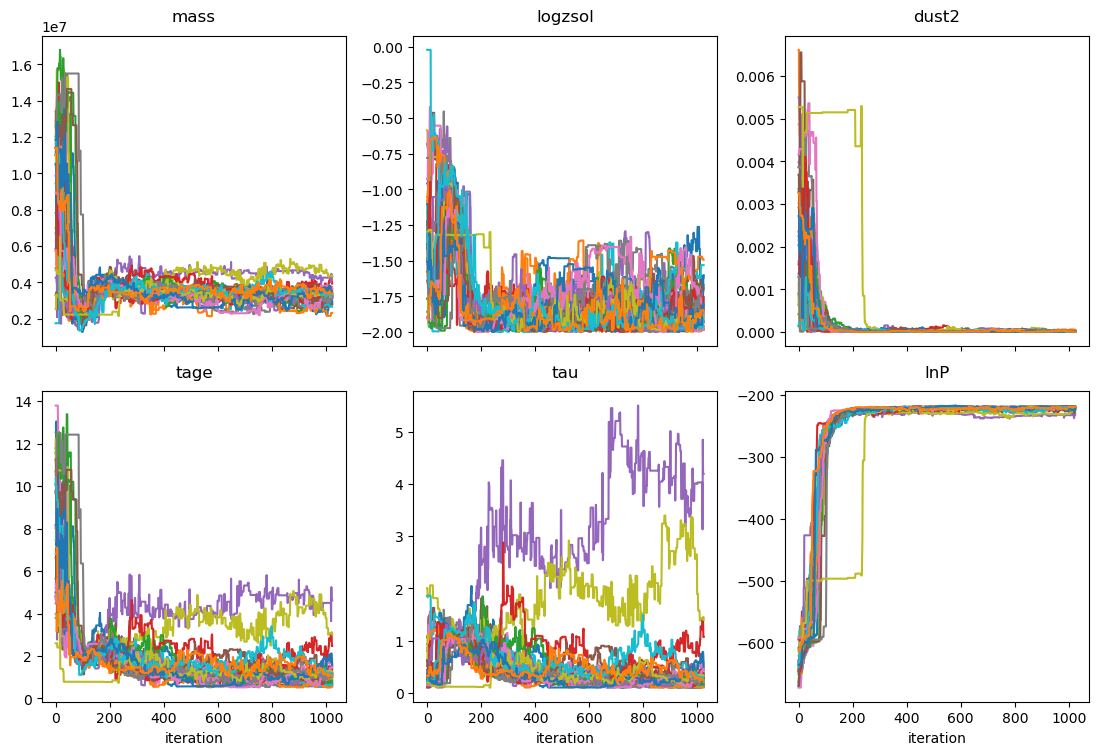

In [4]:
# Trace plots
tfig = reader.traceplot(res)

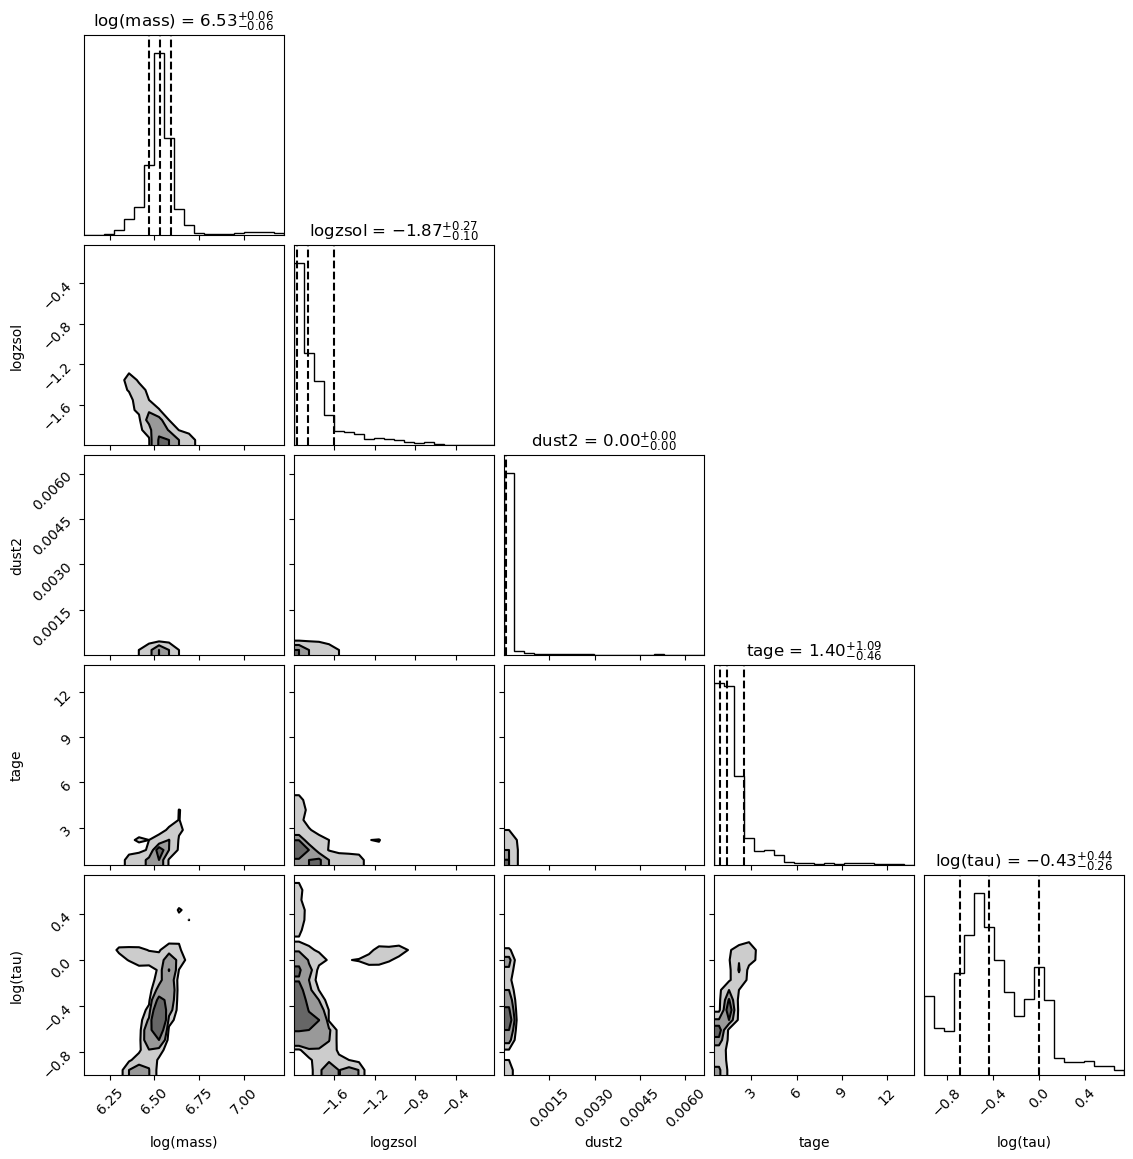

In [5]:
# Corner figure of posterior PDFs
cfig = reader.subcorner(res)

In [9]:
# Maximum posterior probability sample
imax = np.argmax(res['lnprobability'])
csz = res["chain"].shape
if res["chain"].ndim > 2:
    # emcee
    i, j = np.unravel_index(imax, res['lnprobability'].shape)
    theta_max = res['chain'][i, j, :].copy()
    flatchain = res["chain"].reshape(csz[0] * csz[1], csz[2])
else:
    # dynesty
    theta_max = res['chain'][imax, :].copy()
    flatchain = res["chain"]

# 16th, 50th, and 84th percentiles of the posterior
from prospect.plotting.corner import quantile
weights = res.get("weights", None)
post_pcts = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)

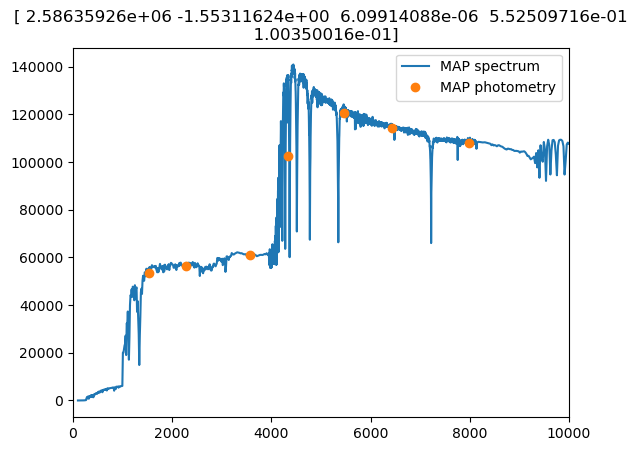

In [15]:
# Plot the stored maximum ln-probability sample
import matplotlib.pyplot as pl

best = res["bestfit"]
a = model.params["zred"] + 1
pl.plot(a * best["restframe_wavelengths"], best['spectrum'], label="MAP spectrum")
if obs['filters'] is not None:
    pwave = [f.wave_effective for f in obs["filters"]]
    pl.plot(pwave, best['photometry'],'o' ,label="MAP photometry")
    pl.title(best["parameter"])
pl.xlim(0,10000.)
pl.legend()

In [16]:
# We need the correct sps object to generate models
sps = reader.get_sps(res)

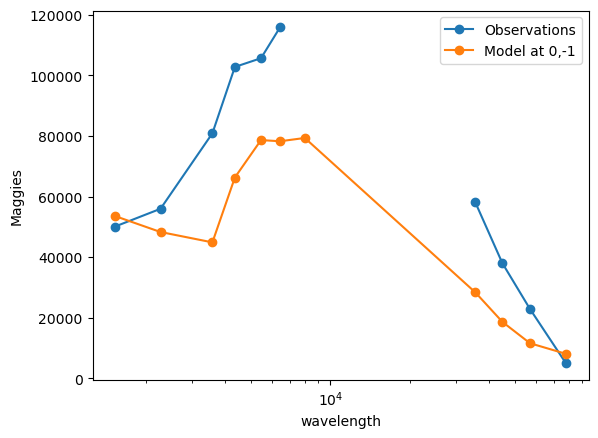

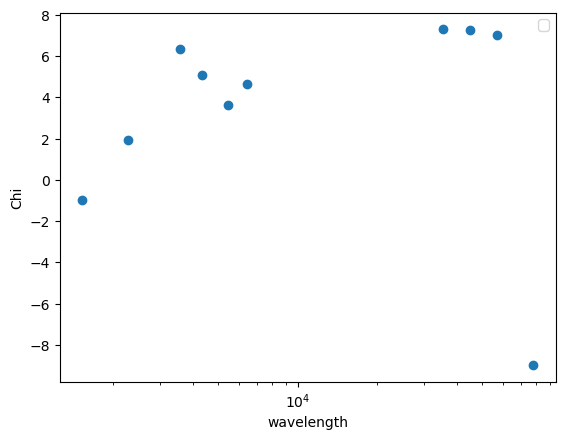

In [18]:
# Choose the walker and iteration number by hand.
walker, iteration = 0, -1
if res["chain"].ndim > 2:
    # if you used emcee for the inference
    theta = res['chain'][walker, iteration, :]
else:
    # if you used dynesty
    theta = res['chain'][iteration, :]

# Or get a fair sample from the posterior
from prospect.plotting.utils import sample_posterior
theta = sample_posterior(res["chain"], weights=res.get("weights", None), nsample=1)[0,:]

# Get the modeled spectra and photometry.
# These have the same shape as the obs['spectrum'] and obs['maggies'] arrays.
spec, phot, mfrac = model.predict(theta, obs=res['obs'], sps=sps)
# mfrac is the ratio of the surviving stellar mass to the formed mass (the ``"mass"`` parameter).

# Plot the model SED
import matplotlib.pyplot as pl
wave = [f.wave_effective for f in res['obs']['filters']]
sedfig, sedax = pl.subplots()
sedax.plot(wave, res['obs']['maggies'], '-o', label='Observations')
sedax.plot(wave, phot, '-o', label='Model at {},{}'.format(walker, iteration))
sedax.set_ylabel("Maggies")
sedax.set_xlabel("wavelength")
sedax.set_xscale('log')
sedax.legend()

# Plot residuals for this walker and iteration
chifig, chiax = pl.subplots()
chi = (res['obs']['maggies'] - phot) / res['obs']['maggies_unc']
chiax.plot(wave, chi, 'o')
chiax.set_ylabel("Chi")
chiax.set_xlabel("wavelength")
chiax.set_xscale('log')
chiax.legend()
